<a href="https://colab.research.google.com/github/gavindoughtie/pytorch_class/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
# Import PyTorch
import torch
from torch import nn

# Import torchivsion
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Check versions
print(torch.__version__)
print(torchvision.__version__)
print(f'device: {device}')


1.13.0+cu116
0.14.0+cu116
device: cpu


## 1. What are 3 areas in industry where computer vision is currently being used?

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find. 

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. 
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [4]:
import requests
from pathlib import Path

# Download helper functions
if Path('helper_functions.py').is_file():
  print(f'helper_functions.py exists, skipping download...')
else:
  print(f'downloading helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

downloading helper_functions.py


In [5]:
# Setup training data

train_data = datasets.MNIST(
    root='data', # where to download data to
    train=True, # get the training dataset rather than testing
    download=True, # do we want to download?
    transform=ToTensor(), # Convert to tensor straight away
    target_transform=None # Do not want to transform the targets (labels)
)

test_data = datasets.MNIST(
    root='data', # where to download data to
    train=False, # get the training dataset rather than testing
    download=True, # do we want to download?
    transform=ToTensor(), # Convert to tensor straight away
    target_transform=None # Do not want to transform the targets (labels)
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

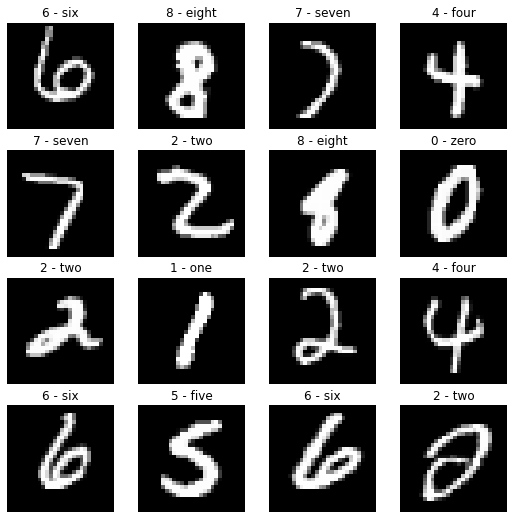

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [8]:
from torch.utils.data import DataLoader

# setup batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f8cf12a4b50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f8cf12a4670>)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [108]:
from traitlets.traitlets import Bool
from collections import OrderedDict

class DebugLayer(nn.Identity):
  def __init__(self, name, debug):
    super().__init__()
    self.name = name
    self.debug = debug if debug else [False]

  def forward(self, x):
    if self.debug[0]:
      print(f'Layer {self}:{self.name} received {x.shape}')
    return super().forward(x)

def make_conv_layer(hidden_units: int,
                    input_shape: int=None,
                    output_shape: int=None,
                    name: str='',
                    use_dropout=False,
                    debug=None) -> nn.Module:
  if input_shape is None:
    input_shape = hidden_units
  if output_shape is None:
    output_shape = hidden_units
  return nn.Sequential(
      DebugLayer(name, debug),
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1), # set some common hyperparameters
      nn.ReLU(),
      nn.Dropout() if use_dropout else nn.Identity(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2))      

class MNISTModelV0(nn.Module):  
  def __init__(self, 
               input_shape, 
               out_features, 
               hidden_units, 
               input_dim=1,
               use_dropout=False,
               device=device,
               cnn_block_count=1):
    super().__init__()
    KERNEL_SIZE = 2
    self.debug=[True]
    cnn_blocks = OrderedDict()
    cnn_blocks['base'] = make_conv_layer(input_shape=input_shape, 
                                         hidden_units=hidden_units,
                                         name='base',
                                         debug=self.debug)
    for block_index in range(cnn_block_count):
      name = f'cnn{block_index}'
      cnn_blocks[name] = make_conv_layer(hidden_units, 
                                         name=name, 
                                         use_dropout=use_dropout, 
                                         debug=self.debug)

    classifier_input_features = int(input_dim / ((2 ** cnn_block_count) * KERNEL_SIZE))
    print(f'classifier_input_features={classifier_input_features}')
    cnn_blocks['classifier'] = nn.Sequential(
        DebugLayer(name='classifier', debug=self.debug),
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*classifier_input_features*classifier_input_features, # todo - trick to calculating this
                  out_features=out_features)
    )

    self.cnn_blocks = nn.Sequential(cnn_blocks)

  def set_debug(self, debug: Bool):
    self.debug[0] = debug

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.cnn_blocks(x)

In [116]:
model_2 = MNISTModelV0(input_shape=1,
                       out_features=len(class_names),
                       input_dim=28,
                       hidden_units=10, 
                       cnn_block_count=2,
                       use_dropout=False,
                       device=device).to(device)

classifier_input_features=3


In [117]:
# make sure the shapes match:
image, label = train_data[0]
print(f'image shape: {image.shape}')
model_2(image.unsqueeze(0).to(device))
model_2.set_debug(False)

image shape: torch.Size([1, 28, 28])
Layer DebugLayer():base received torch.Size([1, 1, 28, 28])
Layer DebugLayer():cnn0 received torch.Size([1, 10, 14, 14])
Layer DebugLayer():cnn1 received torch.Size([1, 10, 7, 7])
Layer DebugLayer():classifier received torch.Size([1, 10, 3, 3])


In [103]:
# Fancier example
def train_step(model: nn.Module, 
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, 
               accuracy_fn,
               device: torch.device=device):
  """Performs a training step with model trying to learn on data_learner."""
  train_loss, train_acc = 0, 0

  # put model into training ode
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    # put data on target devie:
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss per batch
    loss = loss_fn(y_pred, y)

    # accumulate losses
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backprop
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  print(f'train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f}%')


In [104]:
def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
  """Evaluates results of model trained on dataloader"""
  test_loss, test_acc = 0, 0

  # put model into training ode
  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      # put data on target devie:
      X, y = X.to(device), y.to(device)
      # forward pass
      test_pred = model(X)
      # calculate loss
      test_loss += loss_fn(test_pred, y)
      # calculate accuracy
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    print(f'test_loss {test_loss:.5f}, test_acc: {test_acc:.2f}%')


In [105]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time

In [106]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

def train(model, model_name):

  # setup loss function and optimizer
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(
      params=model.parameters(),
      lr=0.1
  )


  # set the seed and start the timer
  torch.manual_seed(42)
  train_time_start_on_cpu = timer()
  device=next(model.parameters()).device
  # set the number of epochs (keep this small for faster training time)
  epochs = 3

  # Create training and test loop
  for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n------')
    train_step(model, train_dataloader, loss_fn, optimizer, accuracy_fn, device=device)
    test_step(model, test_dataloader, loss_fn, accuracy_fn, device=device)

  # calculate training time
  train_time_end_on_cpu = timer()
  total_train_time = print_train_time(start=train_time_start_on_cpu, end=train_time_end_on_cpu, device=device)
  return total_train_time

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [115]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=None):
  """Returns a dictionary containing the results of model predicting on data loader"""
  loss, acc = 0, 0
  if not device:
    device = next(model.parameters()).device

  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X = X.to(device)
      y = y.to(device)
      # make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    # scall the loss and acc to find average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {
      'model_name': model.__class__.__name__, # only works when model was created with a class
      'model_loss': loss.item(),
      'model_acc': acc
  }


In [118]:
train(model_2, 'model_2')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
train_loss: 1.31814, train_acc: 50.75%
test_loss 0.10780, test_acc: 96.47%
Epoch: 1
------
train_loss: 0.10261, train_acc: 96.78%
test_loss 0.06346, test_acc: 98.05%
Epoch: 2
------
train_loss: 0.06953, train_acc: 97.85%
test_loss 0.07190, test_acc: 97.80%
Train time on cpu: 170.533 seconds


170.533143269

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [28]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)
      
      # Get prediction probablility (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # get pred prob onto CPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [29]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

test_samples[0].shape

torch.Size([1, 28, 28])

In [31]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probablilities
pred_probs[:2]

tensor([[6.2743e-07, 1.3398e-09, 1.3848e-05, 9.9998e-01, 9.0865e-11, 2.5498e-06,
         3.2410e-11, 2.8161e-07, 1.0492e-10, 1.3350e-07],
        [8.9331e-07, 9.9940e-01, 2.2581e-05, 1.6901e-05, 7.9232e-06, 5.3601e-06,
         1.7179e-04, 7.9611e-08, 3.7877e-04, 7.5493e-08]])

In [32]:
# Convert probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 1, 6, 6, 9, 4, 4, 8, 3])

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [38]:
# Plot predictions
def plot_predictions(test_samples, pred_classes):
  plt.figure(figsize=(9, 9))
  nrows = 3
  ncols = 3
  for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)

    # plot the target image
    plt.axis(False)
    plt.imshow(sample.squeeze(), cmap='gray')

    # Find the prediction label text
    pred_label = class_names[pred_classes[i]]

    # Get the truth label
    truth_label = class_names[test_labels[i]]

    # Title for the plot
    title_text = f'Pred: {pred_label} | Truth: {truth_label}'

    # Check for equality between pred and truth and change title text color
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c='g')
    else:
      plt.title(title_text, fontsize=10, c='r')

  plt.axis(False)

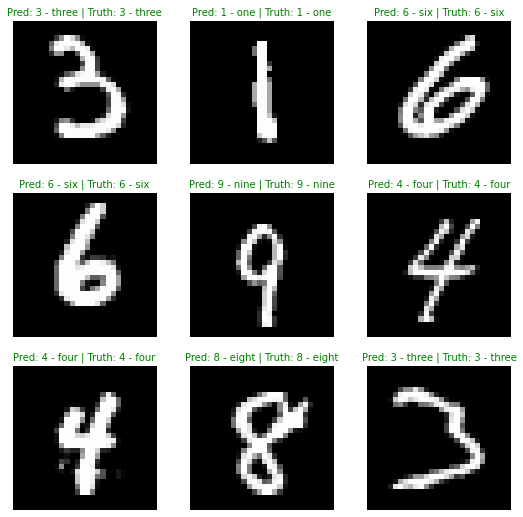

In [39]:
plot_predictions(test_samples, pred_classes)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset. 
* Then plot some predictions where the model was wrong alongside what the label of the image should've been. 
* After visualing these predictions do you think it's more of a modelling error or a data error? 
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?